# Getting started with PyTorch dataloaders
This notebook has contents I learned from here: https://docs.fast.ai/data_block.html

# Vision

In [1]:
from fastai import basic_data

`basic_data` module defines the `DataBunch` class and `DeviceDataLoader` that creates a learner object and wraps the pyTorch data loader respectively. 

In [3]:
from fastai.vision import *

In [9]:
??untar_data

In [40]:
path = untar_data(URLs.MNIST_TINY, dest=Path('data/'))
path.ls()

[PosixPath('data/mnist_tiny/train'),
 PosixPath('data/mnist_tiny/labels.csv'),
 PosixPath('data/mnist_tiny/models'),
 PosixPath('data/mnist_tiny/test'),
 PosixPath('data/mnist_tiny/valid')]

In [20]:
(path/'train').ls()

[PosixPath('data/mnist_tiny/train/7'), PosixPath('data/mnist_tiny/train/3')]

In [23]:
(path/'valid').ls()

[PosixPath('data/mnist_tiny/valid/7'), PosixPath('data/mnist_tiny/valid/3')]

## Folder labelled data - DataBunch
For images in ImageNet style, with train and valid directories, each containing one subdirectory per class, where all the labelled pictures are. There is also a test directory containing unlabelled picture.

In [25]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=64)

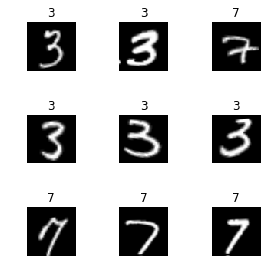

In [30]:
data.show_batch(3, figsize=(4,4))

we can also make above data from the data block API

In [41]:
data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

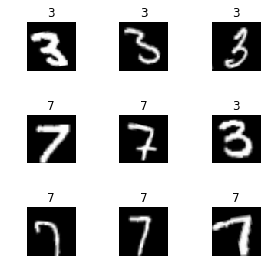

In [42]:
data.show_batch(3, figsize=(4,4))

### Try on personal data

In [43]:
path = Path('data/otae_chan/')
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=64)

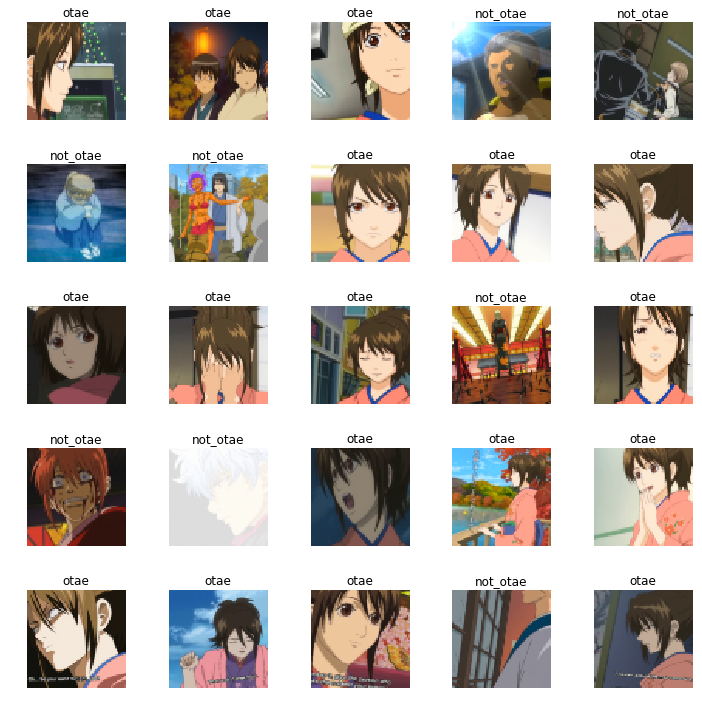

In [37]:
data.show_batch(5, figsize=(10,10))

In [45]:
data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

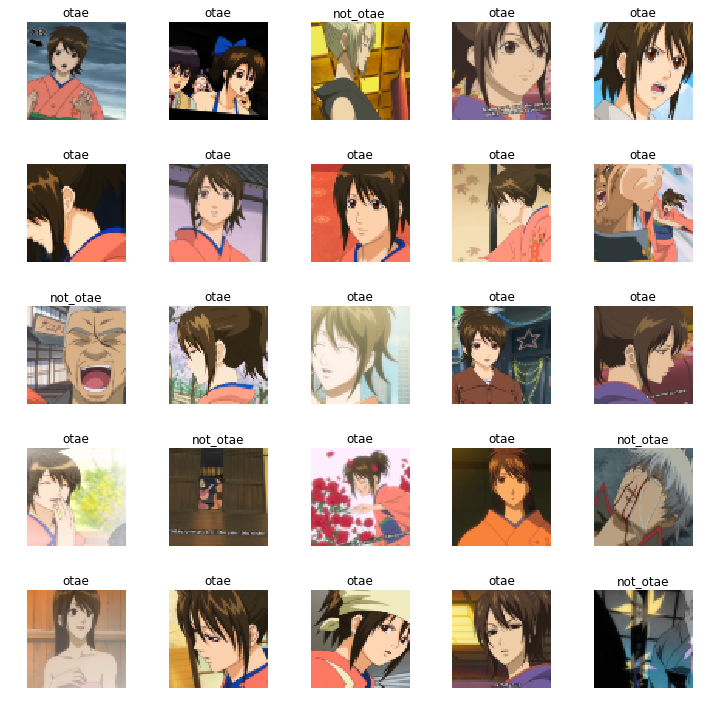

In [46]:
data.show_batch(5, figsize=(10,10))

## CSV labelled data - DataBunch
For images in ImageNet style, with train and valid directories, each containing one subdirectory per class, where all the labelled pictures are. There is also a test directory containing unlabelled picture.

In [49]:
path = untar_data(URLs.PLANET_TINY, dest=Path('data/'))

In [50]:
pd.read_csv(path/"labels.csv").head()

,image_name,tags
0,train_31112,clear primary
1,train_4300,partly_cloudy primary water
2,train_39539,clear primary water
3,train_12498,agriculture clear primary road
4,train_9320,clear primary


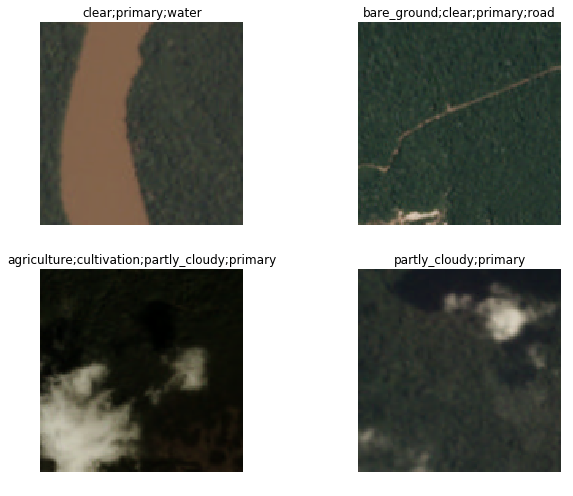

In [56]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_csv(path, folder='train', size=128, suffix='.jpg', label_delim = ' ', ds_tfms=tfms)
data.show_batch(2, figsize=(9,7))

Alternatively, we can again load this using the data API

In [63]:
data = (ImageList.from_csv(path, 'labels.csv', folder='train', suffix='.jpg') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(valid_pct=0.2)              #How to split in train/valid? -> do it randomly, 20% is validation set size
        .label_from_df(label_delim=' ')            #How to label? -> use second columns of the csv
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

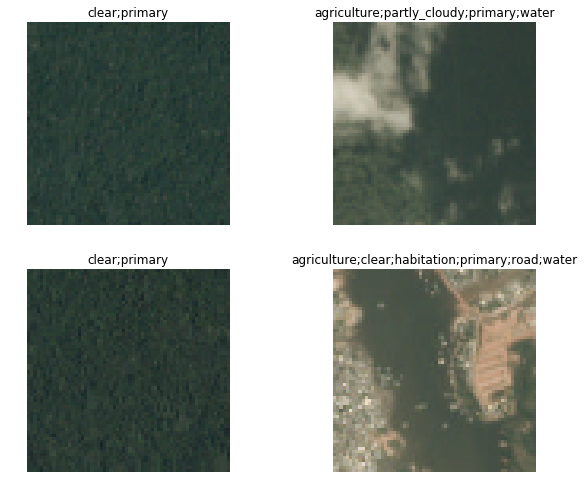

In [64]:
data.show_batch(rows=2, figsize=(9,7))

## More on versatility of data block API
The data block API is very versatile and can be used for various different types of data structures on the disk. Lets test it on the camvid dataset
- We will have to use `SegmentationItemList` here, this class if for vision segmentation tasks with labels over them
- We have to use `tfm_y = True` because labels themselves are images and they need to be transformed too

In [72]:
path = untar_data(URLs.CAMVID_TINY, dest='data/')
path_lbl = path/'labels'
path_img = path/'images'
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [74]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}' #This function will get the labels from mask

In [79]:
??SegmentationItemList.from_folder

In [75]:
data = (SegmentationItemList.from_folder(path_img) #Where to find the data? -> in path_img and its subfolders
        .split_by_rand_pct(0.2)  #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_fn, classes=codes) #How to label? -> use the label function on the file name of the data
        .transform(get_transforms(), tfm_y=True, size=128) #Data augmentation? -> use tfms with a size of 128, also transform the label images
        .databunch()) #Finally -> use the defaults for conversion to databunch

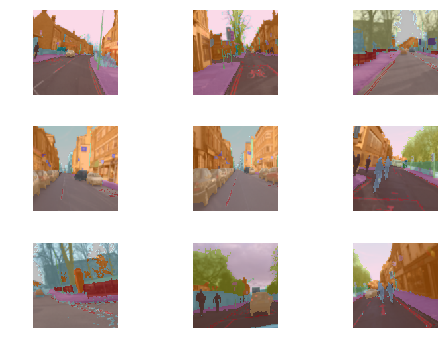

In [80]:
data.show_batch(rows=3, figsize=(7,5))

## Box detection data
There is a helper function in the library that reads the annotation file and returns the list of images names with the list of labelled bboxes associated to it. We convert it to a dictionary that maps image names with their bboxes and then write the function that will give us the target for each image filename.

In [83]:
path = untar_data(URLs.COCO_TINY, dest='data/')
images, lbl_bbox = get_annotations(path/'train.json')

In [86]:
boxdict = dict(zip(images, lbl_bbox))
get_y_func = lambda o:boxdict[o.name]

In [95]:
data = (ObjectItemList.from_folder(path)
        #Where are the images? -> in coco and its subfolders
        .split_by_rand_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(get_transforms(), tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=16, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch, use a batch size of 16,
        # and we use bb_pad_collate to collate the data into a mini-batch

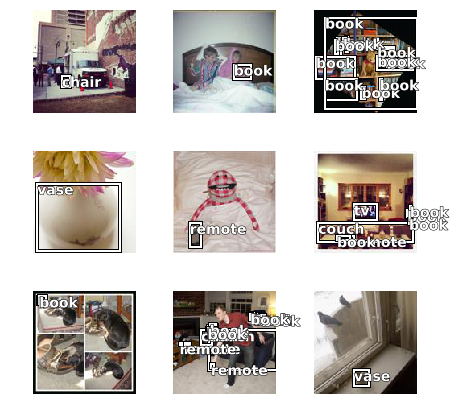

In [99]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(6,6))

# Text

In [100]:
from fastai.text import *

In [107]:
imdb = untar_data(URLs.IMDB_SAMPLE, dest='data/')
data_clas = (TextList.from_csv(imdb, 'texts.csv', cols='text')
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label')
                   .databunch())

In [108]:
data_clas.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


# Tabular

In [109]:
from fastai.tabular import *

- `dep_var` is the dependent variable
- `cat_names` are the categorical variables
- `cont_names` are the continous variables
- `procs` are some of the PreProcessors

In [111]:
adult = untar_data(URLs.ADULT_SAMPLE, dest='data/')
df = pd.read_csv(adult/'adult.csv')
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
cont_names = ['education-num', 'hours-per-week', 'age', 'capital-loss', 'fnlwgt', 'capital-gain']
procs = [FillMissing, Categorify, Normalize]

In [112]:
data = (TabularList.from_df(df, path=adult, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=range(800,1000))
                           .label_from_df(cols=dep_var)
                           .databunch())

In [113]:
data.show_batch()

workclass,education,marital-status,occupation,relationship,race,sex,native-country,education-num_na,education-num,hours-per-week,age,capital-loss,fnlwgt,capital-gain,target
Federal-gov,HS-grad,Never-married,Adm-clerical,Unmarried,White,Female,United-States,False,-0.4224,-0.0356,-0.0430,-0.2164,0.1128,-0.1459,<50k
Private,10th,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,False,-1.5958,-0.0356,-0.9959,-0.2164,-0.3165,-0.1459,<50k
Private,HS-grad,Married-civ-spouse,Tech-support,Husband,White,Male,United-States,False,-0.4224,0.7743,-0.0430,-0.2164,0.6366,-0.1459,>=50k
?,11th,Divorced,?,Not-in-family,White,Female,United-States,False,-1.2046,-0.0356,-1.3624,-0.2164,0.4642,-0.1459,<50k
Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,False,-0.4224,0.3694,-0.1163,-0.2164,-0.4885,-0.1459,<50k
